In [2]:
import pandas as pd
import numpy as np
donor = pd.read_csv("/Users/zhenyuan/Desktop/stern_ra/education/merged_new.csv")
donor = donor.dropna().reset_index()
donor["school_ncesid"] = pd.to_numeric(donor["school_ncesid"], errors='coerce')
donor["ncesid"] = donor["school_ncesid"]//100000
edu = pd.read_csv("/Users/zhenyuan/Desktop/stern_ra/education/seda_cov_geodist_pool_4.1.csv")
edu.dropna(subset=['stateabb'],inplace=True)
data = pd.merge(donor,edu,how='left',left_on="ncesid",right_on="sedalea")
data.dropna(subset=["stateabb"],inplace=True)

In [3]:
gender_nlp = donor.copy()
gender_nlp = gender_nlp[gender_nlp["teacher_prefix"]!='Dr.']
conditions = [(gender_nlp['teacher_prefix']=="Mrs.")|(gender_nlp['teacher_prefix']=="Ms."),
              (gender_nlp['teacher_prefix']=="Mr.")]
values = [0,1]
gender_nlp["gender"] = np.select(conditions,values)
gender_nlp = gender_nlp[["title","short_description","need_statement","essay","gender"]]
gender_nlp = pd.concat([gender_nlp[gender_nlp["gender"]==0].sample(n=2761, random_state=1234),
                        gender_nlp[gender_nlp["gender"]==1]],axis=0).reset_index(drop=True)

In [4]:
from sklearn.utils import shuffle
gender_nlp = shuffle(gender_nlp,random_state=1234).reset_index(drop=True)
gender_nlp.head()

,title,short_description,need_statement,essay,gender
0,Changing Their World at Home and at School: Si...,"It is a high-need community, needing substanti...",My students need DVDs to store their voiced si...,"I am a language specialist, who teaches Englis...",0
1,MLA Handbook for Writers of Research Papers,This book gives examples of research papers an...,"My students need 25 copies of the ""MLA Handboo...",I teach 11th grade English in an extremely hig...,0
2,Sitting Scholars,My five year old students are excited to learn...,My students need a colorful and clean rug.,My five year old students are excited to learn...,0
3,Picture This: Third Grade Photojournalists at ...,"Our photos are so blurry!"" My students frequen...",My students need an easy-to-use high quality d...,"Our photos are so blurry!"" My students frequen...",0
4,Checkout a book-Need cards!,"Read? The students want to , the teachers want...","My students need library cards, pockets, and b...","Read? The students want to , the teachers want...",0


In [5]:
gender_nlp = gender_nlp.rename(columns={"gender":"label"})
gender_nlp.dropna(inplace=True)
gender_nlp.reset_index(inplace=True,drop=True)

In [6]:
first_n_words = 512
def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x
gender_nlp['essay'] = gender_nlp['essay'].apply(trim_string)

In [7]:
from sklearn.model_selection import train_test_split
train, rem = train_test_split(gender_nlp, train_size=0.7,random_state=1234)
val, test = train_test_split(rem, train_size=0.5,random_state=1234)
train.reset_index(inplace=True,drop=True)
val.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [9]:
import csv
header = ["title","short_description","need_statement","essay","label"]
with open('/Users/zhenyuan/Desktop/stern_ra/education/data/train.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(header) 
    for i,row in train.iterrows():
        writer.writerow(row)
with open('/Users/zhenyuan/Desktop/stern_ra/education/data/val.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(header) 
    for i,row in val.iterrows():
        writer.writerow(row)
with open('/Users/zhenyuan/Desktop/stern_ra/education/data/test.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(header) 
    for i,row in test.iterrows():
        writer.writerow(row)

## LSTM
https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

In [10]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [11]:
# Fields
device="cpu"
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('title', text_field), ('short_description', text_field), 
          ('need_statement', text_field),('essay', text_field),
          ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path="/Users/zhenyuan/Desktop/stern_ra/education/data/", train='train.csv', validation='val.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [13]:
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 512)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=512,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [14]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [19]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = "/Users/zhenyuan/Desktop/stern_ra/education/results/lstm",
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for i in train_loader:           
            labels = i.label.to(device)
            text = i.essay[0].to(device)
            text_len = i.essay[1].to(device)
            output = model(text, text_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                    for i in valid_loader:
                        labels = i.label.to(device)
                        text = i.essay[0].to(device)
                        text_len = i.essay[1].to(device)
                        output = model(text, text_len)

                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [60/1210], Train Loss: 0.6876, Valid Loss: 0.6708
Model saved to ==> /Users/zhenyuan/Desktop/stern_ra/education/results/lstm/model.pt
Model saved to ==> /Users/zhenyuan/Desktop/stern_ra/education/results/lstm/metrics.pt
Epoch [1/10], Step [120/1210], Train Loss: 0.6773, Valid Loss: 0.6771
Epoch [2/10], Step [180/1210], Train Loss: 0.6198, Valid Loss: 0.6528
Model saved to ==> /Users/zhenyuan/Desktop/stern_ra/education/results/lstm/model.pt
Model saved to ==> /Users/zhenyuan/Desktop/stern_ra/education/results/lstm/metrics.pt
Epoch [2/10], Step [240/1210], Train Loss: 0.5884, Valid Loss: 0.6558
Epoch [3/10], Step [300/1210], Train Loss: 0.5110, Valid Loss: 0.6527
Model saved to ==> /Users/zhenyuan/Desktop/stern_ra/education/results/lstm/model.pt
Model saved to ==> /Users/zhenyuan/Desktop/stern_ra/education/results/lstm/metrics.pt
Epoch [3/10], Step [360/1210], Train Loss: 0.4358, Valid Loss: 0.6522
Model saved to ==> /Users/zhenyuan/Desktop/stern_ra/education/results/l

Model loaded from <== /Users/zhenyuan/Desktop/stern_ra/education/results/lstm/metrics.pt


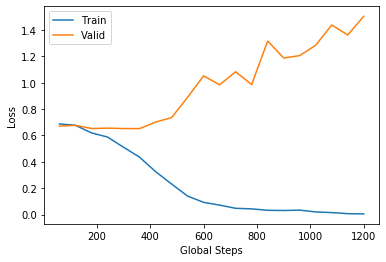

In [21]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('/Users/zhenyuan/Desktop/stern_ra/education/results/lstm' + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model loaded from <== /Users/zhenyuan/Desktop/stern_ra/education/results/lstm/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.6326    0.6978    0.6636       417
           0     0.6585    0.5898    0.6223       412

    accuracy                         0.6441       829
   macro avg     0.6456    0.6438    0.6430       829
weighted avg     0.6455    0.6441    0.6431       829



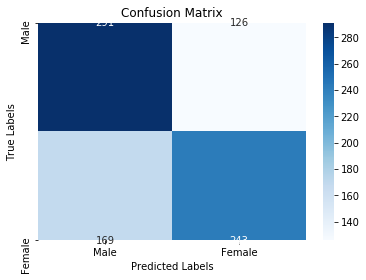

In [23]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for i in test_loader:           
            labels = i.label.to(device)
            text = i.essay[0].to(device)
            text_len = i.essay[1].to(device)
            output = model(text, text_len)
            
            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Male', 'Female'])
    ax.yaxis.set_ticklabels(['Male', 'Female'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('/Users/zhenyuan/Desktop/stern_ra/education/results/lstm' + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)